[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
# Enable everything in glcm but SumAverage
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()

kmeans = KMeans(n_clusters=2, random_state=0)

In [2]:
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    print(Counter(labels))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(raw_image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+',
                cmap=matplotlib.colors.ListedColormap(['yellow', 'red']), linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=300)

def extract_features(raw_image):
    blurred = cv2.GaussianBlur(raw_image,(5,5),cv2.BORDER_DEFAULT)

    threshold, binarized = \
        cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    binarized = np.uint8(blurred < threshold)
    binarized = apply_imfill(apply_closure(binarized, kernel_size=7))

    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(binarized, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < 100:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(sitk.GetImageFromArray(raw_image),
                                   sitk.GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features), np.array(masks)

def process_features(df):
    return df
#     return pd.DataFrame(scaler.transform(df.values),
#                         index=df.index, columns=df.columns)

# Fit k-means classifier on control image

,x,y,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,541,14,0.481698,31.313664,29.5296461204668,296.5,15.083725,83.94112549695433,0.28310666272159973,297.0,...,85.53872053872054,0.9973358727567482,11.336700336700337,27.242424242424242,283.33670033670035,3.6620080433969324,0.1335680882903105,0.10152578898500417,1.5460255177329694,0.010381729433435538
1,574,10,0.490069,34.590539,34.058772731852805,277.5,16.951746,103.35533905932749,0.37245167228586484,278.0,...,82.4748201438849,1.651635526111485,8.679856115107913,26.46043165467626,158.83812949640287,8.153739967209907,0.26435926768789053,0.11379005015941894,1.442266665125949,0.01914674623679741
2,620,7,0.780572,15.543258,16.15549442140351,139.5,12.132625,49.455844122715675,0.3545221800911518,140.0,...,44.02857142857143,0.8540816326530611,8.614285714285714,21.857142857142858,149.62857142857143,4.388847222222223,0.188593253968254,0.1276739676690782,1.3964968505920887,0.02103975065968848
3,1087,18,0.433685,94.869485,111.31936040060597,2300.5,41.143513,312.12489168102843,0.13567697964834968,2301.0,...,414.5010864841373,2.8260195621917497,20.055193394176445,23.63885267275098,403.93003042155584,2.702031699125962,0.10773258226866647,0.11838419784512062,2.9468357378604213,0.01081033562367302
4,321,21,0.450911,35.817751,35.12833614050059,419.5,16.150621,93.94112549695433,0.22393593682229876,420.0,...,99.36666666666666,1.716190476190476,14.676190476190476,22.34285714285714,296.3142857142857,2.6214689018464528,0.11219688748515279,0.11371603551032405,1.9805978288581747,0.012547479937313453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,297,815,0.571823,33.556649,30.805843601498726,342.5,19.188475,109.84062043356604,0.32070254141187166,343.0,...,74.8192419825073,2.70134042788294,17.62390670553936,17.431486880466473,277.7113702623907,1.705447449144867,0.11828138554849647,0.1791116975620828,4.000729389099339,0.02204485644862031
121,972,819,0.578584,38.437603,36.40054944640259,318.5,22.239397,126.18376618407368,0.3961813694947368,319.0,...,65.47021943573668,2.57772624089779,13.003134796238244,14.009404388714733,132.25705329153604,3.4640697216713225,0.21077783020209123,0.20478081305667512,3.9387558155446083,0.030344434186655042
122,174,817,0.475040,32.603667,29.546573405388315,297.5,15.488061,92.28427124746189,0.3101992310839055,298.0,...,100.22818791946308,1.3636773118328005,9.926174496644295,26.7248322147651,238.16107382550337,4.658222237440838,0.18945825533792937,0.09937582222797148,1.1718598099194937,0.01872425969832101
123,401,812,0.338248,27.112035,23.853720883753127,141.5,9.170584,65.89949493661166,0.46572081227287393,142.0,...,78.64788732394366,1.3209680618924817,6.591549295774648,38.014084507042256,162.92957746478874,10.085670491201176,0.2993034796078055,0.12539318583458423,1.8413614757327028,0.0272362099182396


Counter({1: 116, 0: 9})


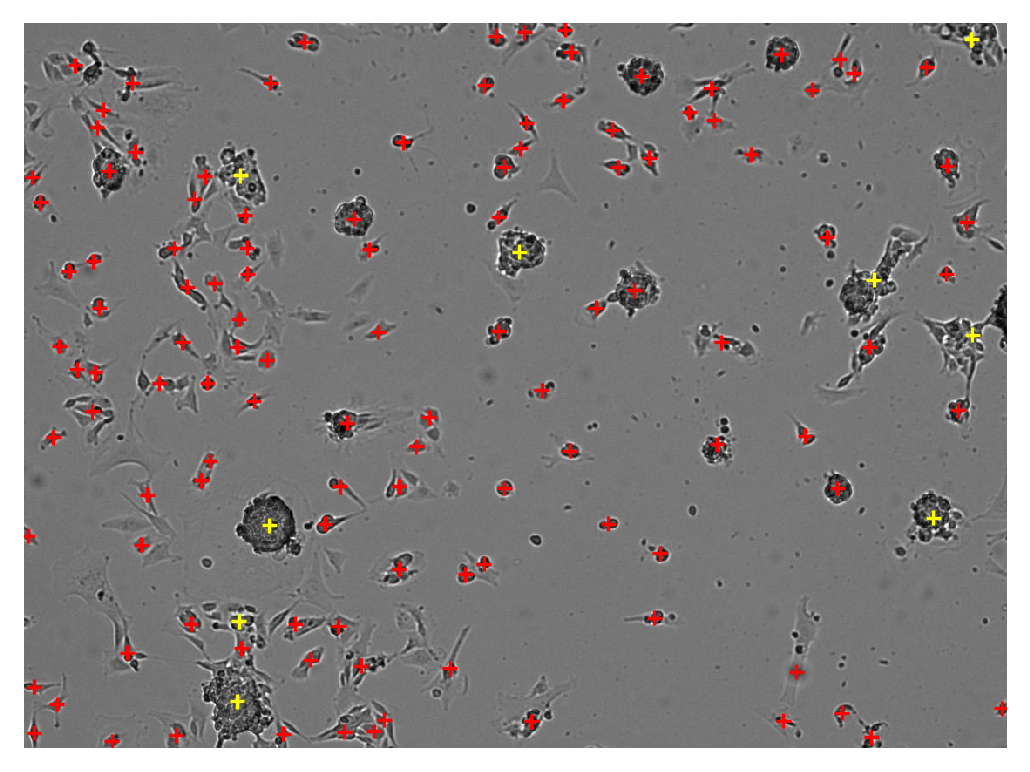

Class 0, with 9 ROIs:


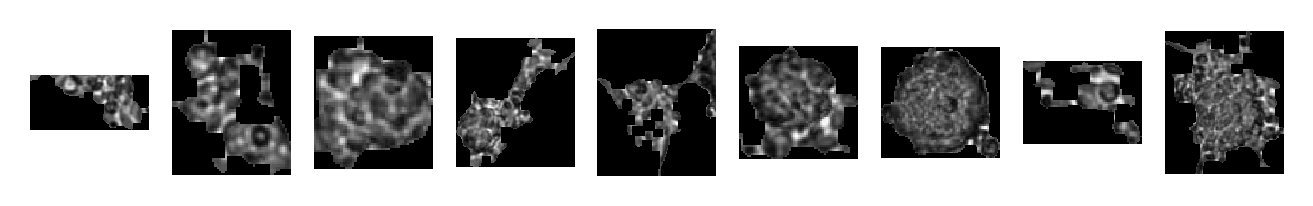

Class 1, with 116 ROIs:


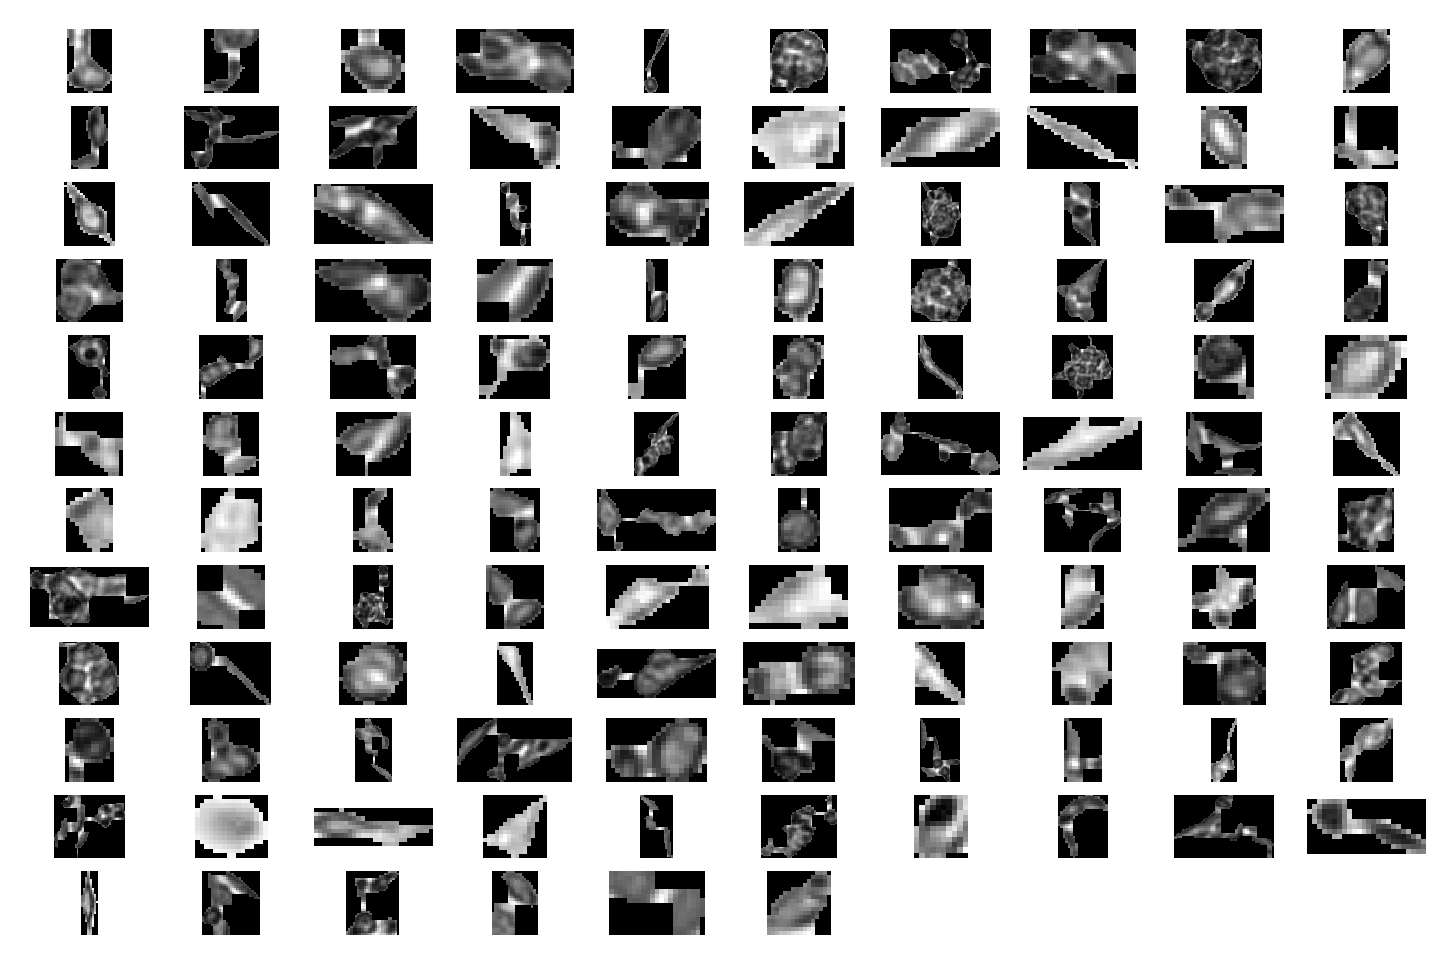

In [3]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
df, masks = extract_features(raw_image)
display(df)

feature_df = df.drop(['x', 'y'], axis=1)
scaler.fit(feature_df.values)
feature_df = process_features(feature_df)
kmeans.fit(feature_df)
labels = kmeans.predict(feature_df)

display_classifications(raw_image, np.array(df[['x', 'y']]), labels)
display_rois(raw_image, masks, labels)

# Experiment w/ multi-Otsu

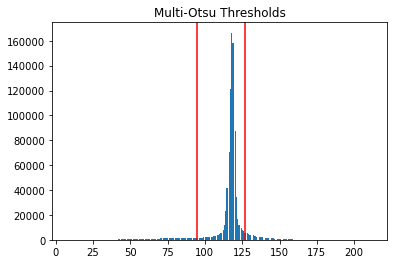

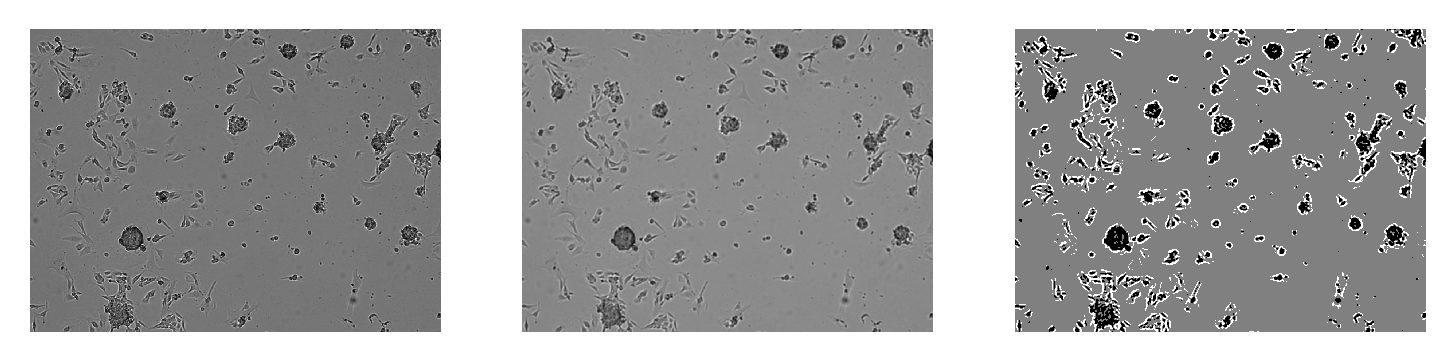

In [4]:
blurred = cv2.GaussianBlur(raw_image,(5,5),cv2.BORDER_DEFAULT)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent and suspension images

Counter({1: 74, 0: 8})


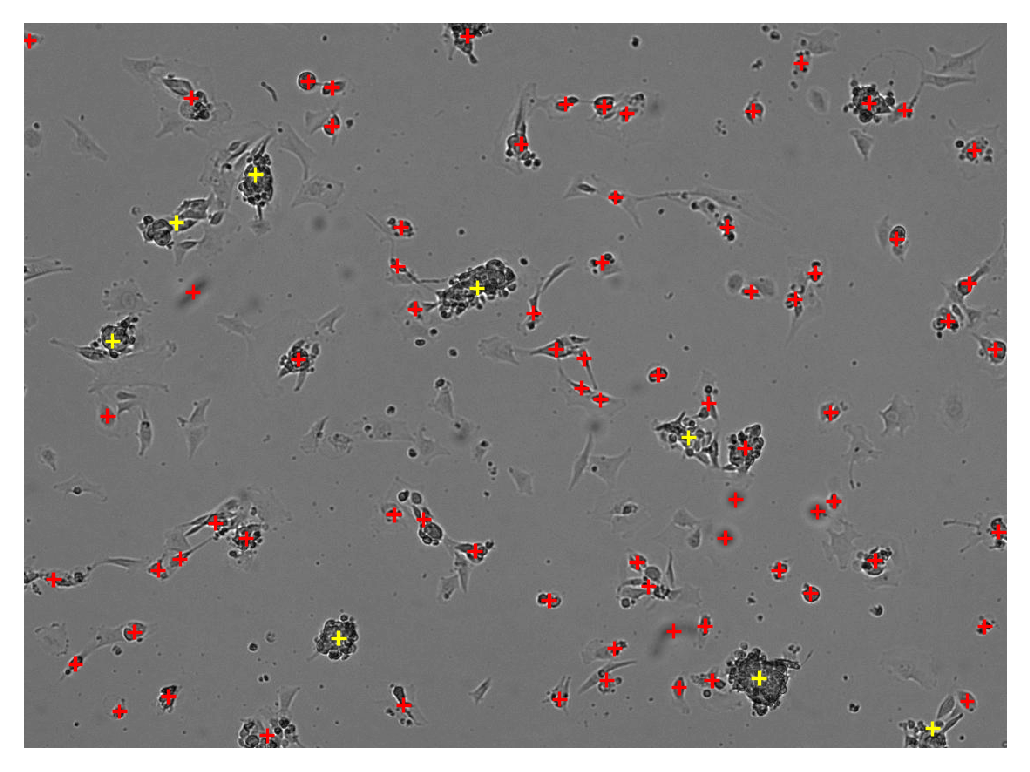

Class 0, with 8 ROIs:


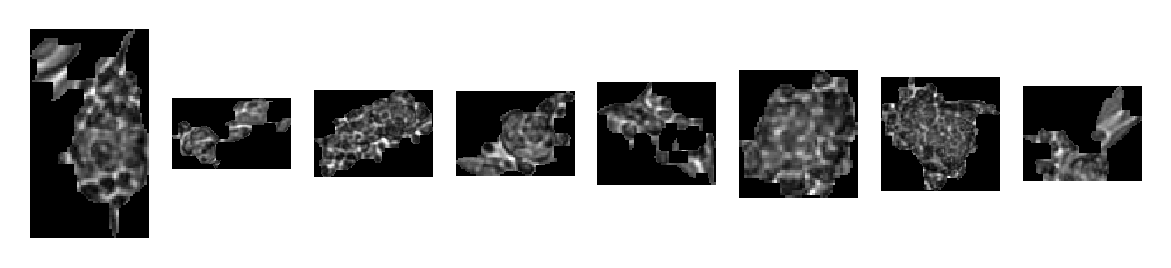

Class 1, with 74 ROIs:


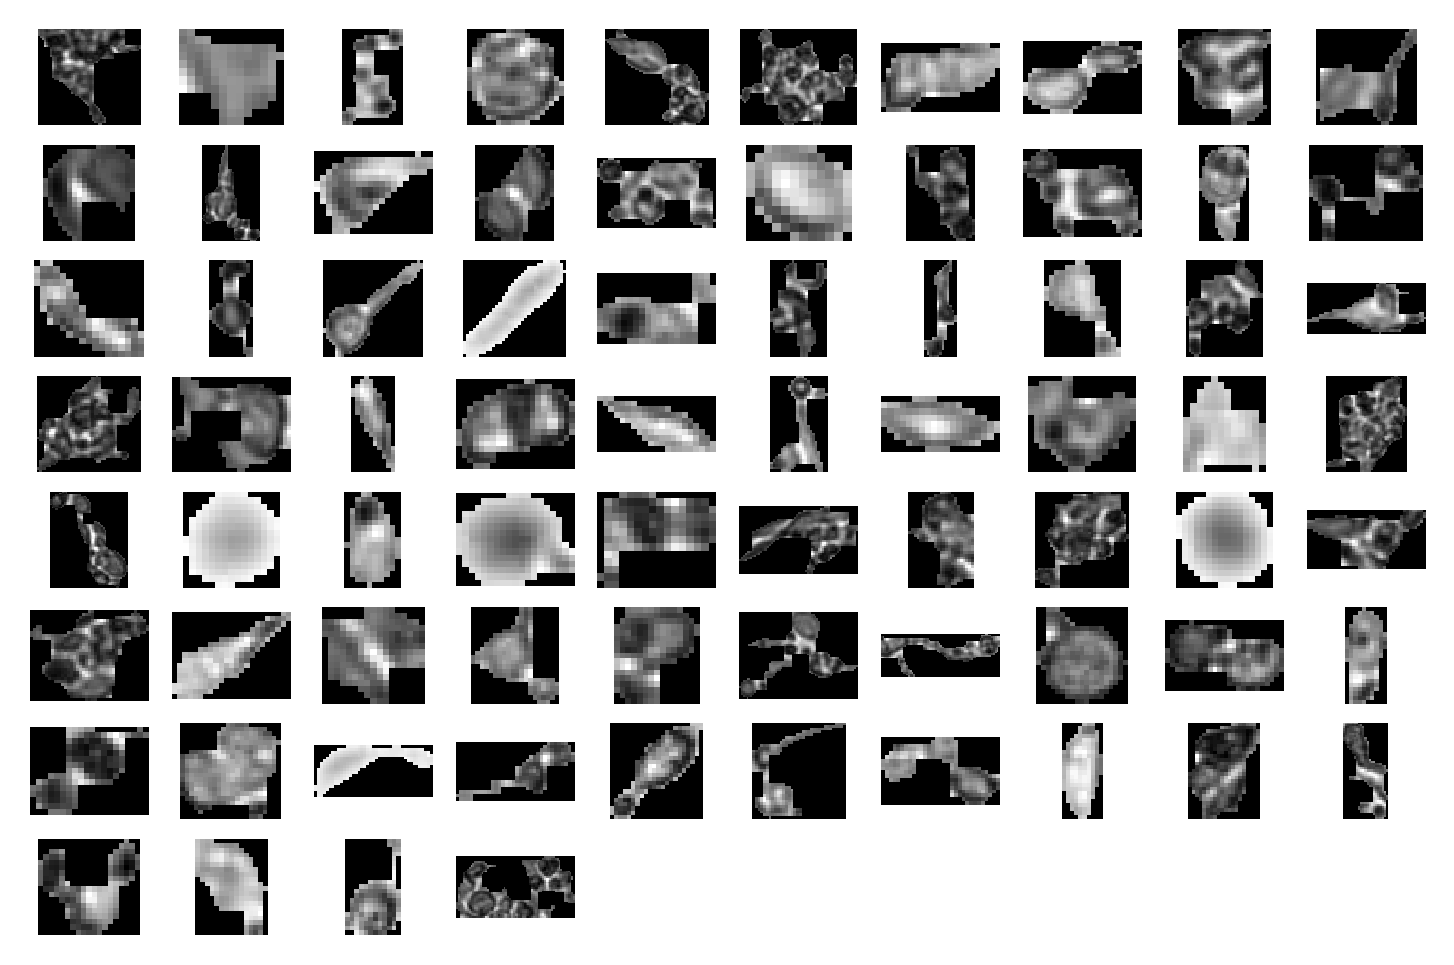

In [5]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
df, masks = extract_features(raw_image)
feature_df = process_features(df.drop(['x', 'y'], axis=1))
labels = kmeans.predict(feature_df)
display_classifications(raw_image, np.array(df[['x', 'y']]), labels)
display_rois(raw_image, masks, labels)

Counter({1: 84, 0: 3})


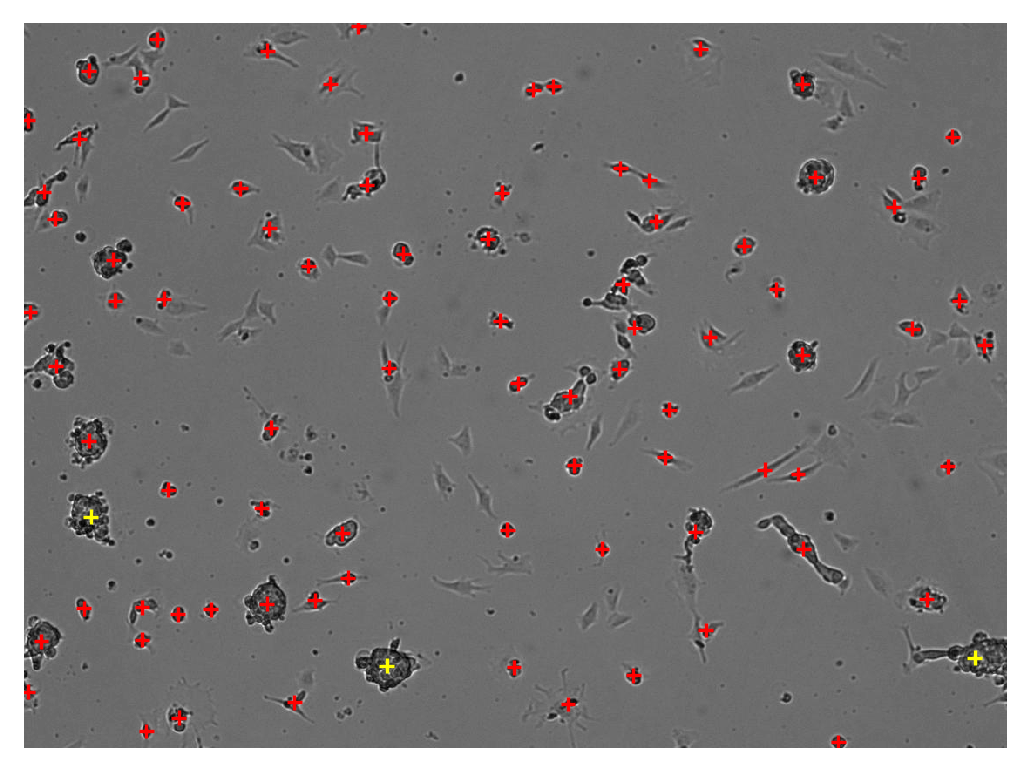

Class 0, with 3 ROIs:


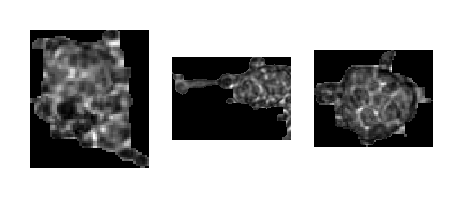

Class 1, with 84 ROIs:


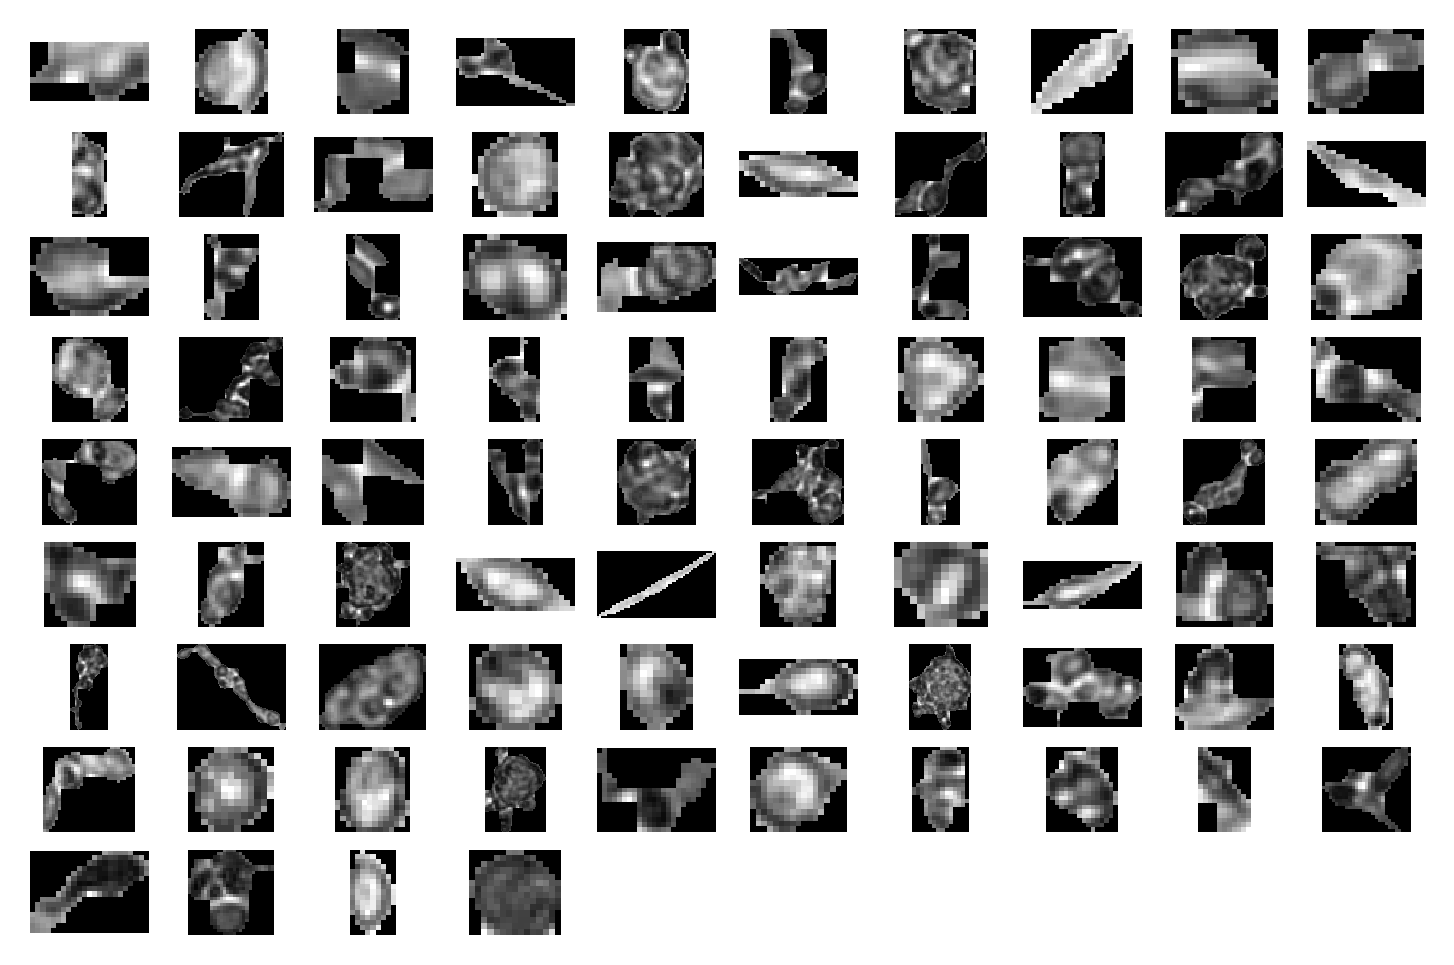

In [6]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
df, masks = extract_features(raw_image)
feature_df = process_features(df.drop(['x', 'y'], axis=1))
labels = kmeans.predict(feature_df)
display_classifications(raw_image, np.array(df[['x', 'y']]), labels)
display_rois(raw_image, masks, labels)